# Creazione dataset

## generazione immagini

In [ ]:
#!pip install Pillow numpy pandas torch torchvision
!pip install pandas joblib torch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/xpu


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://download.pytorch.org/whl/xpu

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch
torch.xpu.is_available()

True

In [1]:
dataset_dir = f"./digit_dataset"

In [2]:
from PIL import Image, ImageDraw, ImageFont
import os, numpy as np, pandas as pd, torch
import random
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms # Import the transforms module

predisporre all'interno della cartella `./fonts` i font da cui verranno generati i caratteri

In [4]:
# Parametri
#chars_to_generate = np.array(list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789,;.:!?'()[]{}<>/\\@#$€£%&~aèéìòù-+°"))

img_size = (28, 28)

fonts_path = [os.path.join(f"./fonts", file) for file in os.listdir(f"./fonts") if file.endswith(".ttf")]
fonts_name = [os.path.splitext(os.path.basename(file))[0] for file in fonts_path]
print(fonts_path)

font_size = 20


['./fonts/Antonio-Bold.ttf', './fonts/Antonio-Light.ttf', './fonts/Antonio-Regular.ttf', './fonts/CaviarDreams.ttf', './fonts/Caviar_Dreams_Bold.ttf', './fonts/Courier Prime Bold.ttf', './fonts/Courier Prime.ttf', './fonts/JosefinSans-Bold.ttf', './fonts/JosefinSans-Light.ttf', './fonts/JosefinSans-Regular.ttf', './fonts/JosefinSans-SemiBold.ttf', './fonts/JosefinSans-Thin.ttf', './fonts/Lato-Black.ttf', './fonts/Lato-Bold.ttf', './fonts/Lato-Hairline.ttf', './fonts/Lato-Heavy.ttf', './fonts/Lato-Light.ttf', './fonts/Lato-Medium.ttf', './fonts/Lato-Regular.ttf', './fonts/Lato-Semibold.ttf', './fonts/Lato-Thin.ttf', './fonts/Muli-Bold.ttf', './fonts/Muli-ExtraLight.ttf', './fonts/Muli-Light.ttf', './fonts/Muli-SemiBold.ttf', './fonts/Muli.ttf', './fonts/OpenSans-Bold.ttf', './fonts/OpenSans-ExtraBold.ttf', './fonts/OpenSans-Light.ttf', './fonts/OpenSans-Regular.ttf', './fonts/OpenSans-Semibold.ttf', './fonts/Oswald-Bold.ttf', './fonts/Oswald-DemiBold.ttf', './fonts/Oswald-ExtraLight.ttf

In [5]:
# Crea la directory principale
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

In [6]:
import os
from PIL import Image, ImageDraw, ImageFont

def get_character_margins(font_path, char, img_size):
	"""
	This function generates an image of a fixed size letter char in the given font.
	Then, it counts the empty pixel above and bottom the letter and return the two numbers to the caller.
	"""

	# Set background and text colors
	background_color = 'black'
	text_color = 'white'

	# Create a new image with the specified size and background color
	img = Image.new('RGB', img_size, color=background_color)
	draw = ImageDraw.Draw(img)

	# Load the font with a specified size
	font_size = 20
	font = ImageFont.truetype(font_path, font_size)

	# Get text size
	try:
		# Use textbbox for newer Pillow versions
		bbox = draw.textbbox((0, 0), char, font=font)
		text_width = bbox[2] - bbox[0]
		text_height = bbox[3] - bbox[1]
	except AttributeError:
		# Fallback to textsize for older Pillow versions
		text_width, text_height = draw.textsize(char, font=font)

	# Calculate the position to center the text in the image
	x = (img_size[0] - text_width) / 2
	y = (img_size[1] - text_height) / 2

	# Draw the text on the image
	draw.text((x, y), char, fill=text_color, font=font)

	# Convert the image to grayscale
	img = img.convert('L')

	# Get pixel data
	pixels = img.load()

	# Count empty pixels from the top
	top_margin = 0
	for i in range(img_size[1]):
		row_empty = True
		for j in range(img_size[0]):
			if pixels[j, i] != 0:  # Assuming 0 is the background color in grayscale
				row_empty = False
				break
		if row_empty:
			top_margin += 1
		else:
			break

	# Count empty pixels from the bottom
	bottom_margin = 0
	for i in range(img_size[1] - 1, -1, -1):
		row_empty = True
		for j in range(img_size[0]):
			if pixels[j, i] != 0:  # Assuming 0 is the background color in grayscale
				row_empty = False
				break
		if row_empty:
			bottom_margin += 1
		else:
			break

	img.save("temp_img.png")

	if top_margin == img_size[0] or bottom_margin == img_size[0]:
		raise Exception(font_path+" "+char)

	return top_margin, bottom_margin
	
	

In [7]:
chars_to_generate = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789,;.:!?'()[]{}<>/\\@#$€£%&~aèéìòù-+°"

def get_margin_information(font):
	margin_dict = {}
	top_margins = set()
	bottom_margins = set()
	for c in chars_to_generate:
		resolution = (50, 50)
		t = get_character_margins(
			font_path=font,
			char=c,
			img_size=resolution
		)
		t = (t[0] / resolution[1], t[1] / resolution[1])
		margin_dict[c] = t
		top_margins.add(t[0])
		bottom_margins.add(t[1])

	permutations = [(x,y) for x in top_margins for y in bottom_margins]
	return margin_dict, permutations

In [10]:
get_margin_information(fonts_path[0])


({'A': (0.44, 0.22),
  'B': (0.44, 0.22),
  'C': (0.44, 0.22),
  'D': (0.44, 0.22),
  'E': (0.44, 0.22),
  'F': (0.44, 0.22),
  'G': (0.44, 0.22),
  'H': (0.44, 0.22),
  'I': (0.44, 0.22),
  'J': (0.44, 0.22),
  'K': (0.44, 0.22),
  'L': (0.44, 0.22),
  'M': (0.44, 0.22),
  'N': (0.44, 0.22),
  'O': (0.44, 0.22),
  'P': (0.44, 0.22),
  'Q': (0.42, 0.18),
  'R': (0.44, 0.22),
  'S': (0.44, 0.22),
  'T': (0.44, 0.22),
  'U': (0.44, 0.22),
  'V': (0.44, 0.22),
  'W': (0.44, 0.22),
  'X': (0.44, 0.22),
  'Y': (0.44, 0.22),
  'Z': (0.44, 0.22),
  'a': (0.5, 0.2),
  'b': (0.42, 0.22),
  'c': (0.5, 0.2),
  'd': (0.42, 0.22),
  'e': (0.5, 0.2),
  'f': (0.42, 0.22),
  'g': (0.48, 0.18),
  'h': (0.42, 0.22),
  'i': (0.38, 0.24),
  'j': (0.36, 0.22),
  'k': (0.42, 0.22),
  'l': (0.42, 0.22),
  'm': (0.5, 0.2),
  'n': (0.5, 0.2),
  'o': (0.5, 0.2),
  'p': (0.48, 0.18),
  'q': (0.48, 0.18),
  'r': (0.5, 0.2),
  's': (0.5, 0.2),
  't': (0.44, 0.22),
  'u': (0.5, 0.2),
  'v': (0.5, 0.2),
  'w': (0.5,

In [8]:
import os
from PIL import Image, ImageDraw, ImageFont

# Assume necessary variables are defined elsewhere, for example:
# dataset_dir = "generated_dataset"
# fonts_path = ["/path/to/your/font1.ttf", "/path/to/your/font2.otf"] # Replace with actual font paths
# chars_to_generate = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
# img_size = (64, 64) # Target image size (width, height)
# text_colors = [(0, 0, 0), (255, 255, 255)] # Black and White
# background_colors = [(255, 255, 255), (0, 0, 0)] # White and Black


def get_ink_bbox(image, background_color, tolerance=5):
	"""
	Finds the tight bounding box of non-background pixels in an image.

	Args:
		image: PIL Image object.
		background_color: The background color tuple (R, G, B).
		tolerance: Allows for a small difference in color to be considered background.

	Returns:
		A tuple (left, top, right, bottom) representing the ink bounding box,
		or None if the image is all background within the tolerance.
	"""
	width, height = image.size
	left, top = width, height
	right, bottom = -1, -1

	# Ensure background_color is in the same mode as the image for comparison
	try:
		# Create a 1x1 image with the background color in the target image mode
		bg_color_check = Image.new(image.mode, (1, 1), color=background_color).getpixel((0, 0))
	except Exception:
		# print(f"Warning: Could not match background color mode for ink bbox detection. Using provided background_color directly.")
		bg_color_check = background_color

	pixels = image.load()

	def is_background(pixel, bg_color, tol):
		# Compare pixel color to background color within tolerance
		if isinstance(pixel, tuple) and isinstance(bg_color, tuple):
			 if len(pixel) == len(bg_color):
				 return all(abs(p - bg) <= tol for p, bg in zip(pixel, bg_color))
			 elif len(pixel) == 4 and len(bg_color) == 3: # Compare RGBA pixel to RGB background (ignore alpha of pixel)
				  return all(abs(pixel[i] - bg_color[i]) <= tol for i in range(3))
		elif isinstance(pixel, int) and isinstance(bg_color, int): # Handle grayscale or paletted images
			 return abs(pixel - bg_color) <= tol
		return pixel == bg_color # Fallback for exact match if types are unexpected


	for y in range(height):
		for x in range(width):
			if not is_background(pixels[x, y], bg_color_check, tolerance):
				left = min(left, x)
				top = min(top, y)
				right = max(right, x)
				bottom = max(bottom, y)

	if right == -1: # Image is all background within tolerance
		return None

	return (left, top, right, bottom)

def generate_character_image(font_path, char, img_size, img_path):
	"""
	Generates an image for a single character with specified spacing.

	Args:
		font_path: Path to the font file.
		char: The character to render.
		text_color: The color of the text (R, G, B).
		background_color: The background color (R, G, B).
		img_size: The target size of the output image (width, height).
		dataset_dir: The base directory for the dataset.
		char_idx: The index of the character (for directory naming).
		top_space: The number of pixels to leave as empty space at the top.
		bottom_space: The number of pixels to leave as empty space at the bottom.

	Returns:
		The relative path to the saved image if successful, None otherwise.
	"""

	text_color = 'white'
	background_color = 'black'

	# Use a large initial font size for accurate ink bbox measurement
	initial_font_size_for_bbox = 100 # Increased initial size for better accuracy
	# Create a temporary image much larger than the initial font size
	# This ensures the entire glyph is captured, even for characters
	# with large ascenders/descenders or unusual placements.
	temp_img_size = (initial_font_size_for_bbox * 4, initial_font_size_for_bbox * 4)

	# Create a temporary image and draw object
	# Use 'RGB' mode for consistency in pixel analysis
	temp_img = Image.new('RGB', temp_img_size, color=background_color)
	temp_draw = ImageDraw.Draw(temp_img)

	# Load the font with the initial large size
	initial_font = ImageFont.truetype(font_path, initial_font_size_for_bbox)

	# Get the layout bounding box of the character with the initial font
	# This is used to position the character on the temporary image
	# relative to where Pillow thinks its origin is.
	try:
		# Use textbbox for newer Pillow versions
		temp_layout_bbox = temp_draw.textbbox((0, 0), char, font=initial_font)
	except AttributeError:
			# Fallback to textsize for older Pillow versions
			temp_text_width, temp_text_height = temp_draw.textsize(char, font=initial_font)
			temp_layout_bbox = (0, 0, temp_text_width, temp_text_height) # Approximate bbox

	temp_text_width = temp_layout_bbox[2] - temp_layout_bbox[0]
	temp_text_height = temp_layout_bbox[3] - temp_layout_bbox[1]

	# Calculate drawing position on the temporary image to roughly center the layout bbox
	# Adding a buffer to ensure ink is not clipped at edges
	buffer = initial_font_size_for_bbox // 2
	draw_x_temp = (temp_img_size[0] - temp_text_width) / 2 - temp_layout_bbox[0] + buffer
	draw_y_temp = (temp_img_size[1] - temp_text_height) / 2 - temp_layout_bbox[1] + buffer


	# Draw the character on the temporary image
	temp_draw.text((draw_x_temp, draw_y_temp), char, fill=text_color, font=initial_font)

	# Find the tight ink bounding box on the temporary image
	# Use a small tolerance to account for anti-aliasing
	ink_bbox = get_ink_bbox(temp_img, background_color, tolerance=10) # Increased tolerance slightly

	if ink_bbox is None:
			print(f"Warning: Could not find ink for character '{char}' with font '{font_path}'. Skipping this combination.")
			return

	ink_left, ink_top, ink_right, ink_bottom = ink_bbox
	ink_width = ink_right - ink_left + 1 # Add 1 because bbox is inclusive
	ink_height = ink_bottom - ink_top + 1 # Add 1

	if ink_width <= 0 or ink_height <= 0:
			print(f"Warning: Ink bounding box has zero or negative dimension for character '{char}' with font '{font_path}'. Skipping this combination.")
			return

	# Calculate the effective height for scaling, considering top and bottom space
	effective_height = img_size[1]
	if effective_height <= 0:
			print(f"Error: Effective height for character '{char}' with font '{font_path}' is zero or negative after applying top/bottom space. Skipping.")
			return

	# Calculate scaling factor based on ink bbox and the effective image size
	width_ratio = img_size[0] / ink_width
	height_ratio = effective_height / ink_height
	scale_factor = min(width_ratio, height_ratio)

	# Calculate the optimal font size
	optimal_font_size = int(initial_font_size_for_bbox * scale_factor)

	# Ensure optimal font size is reasonable
	if optimal_font_size <= 0:
		optimal_font_size = 1
		print(f"Warning: Calculated optimal font size for character '{char}' with font '{font_path}' is too small. Setting to 1.")
	# Prevent excessively large font sizes that could cause memory issues or errors
	elif optimal_font_size > 500: # Increased arbitrary cap
			optimal_font_size = 500
			print(f"Warning: Calculated optimal font size for character '{char}' with font '{font_path}' is excessively large. Capping at {optimal_font_size}.")


	# Create the final image with the correct size and background
	img = Image.new('RGB', img_size, color=background_color)
	draw = ImageDraw.Draw(img)

	# Create the font instance with the optimal size
	if optimal_font_size <= 0:
			print(f"Error: Optimal font size for character '{char}' with font '{font_path}' is invalid ({optimal_font_size}). Skipping drawing.")
			return
	font = ImageFont.truetype(font_path, optimal_font_size)

	# Calculate the expected ink bbox at the optimal size by scaling
	# The ink bbox coordinates on the temporary image are relative to its top-left corner.
	# We need their position relative to the draw origin on the temporary image.
	ink_bbox_relative_to_draw_temp = (ink_left - draw_x_temp, ink_top - draw_y_temp, ink_right - draw_x_temp, ink_bottom - draw_y_temp)

	# Scale these relative coordinates to the optimal font size scale
	scaled_ink_left = ink_bbox_relative_to_draw_temp[0] * scale_factor
	scaled_ink_top = ink_bbox_relative_to_draw_temp[1] * scale_factor
	scaled_ink_right = ink_bbox_relative_to_draw_temp[2] * scale_factor
	scaled_ink_bottom = ink_bbox_relative_to_draw_temp[3] * scale_factor

	# Calculate the drawing position on the final image to center the scaled ink bbox
	# within the effective height (img_size[1] - top_space - bottom_space) starting at top_space.
	# The draw.text position (x, y) is the top-left of the text's layout bounding box.
	# We want the center of the scaled ink bbox to be at the horizontal center of the image
	# and vertically centered within the effective height area.

	center_x_img = img_size[0] / 2
	center_y_effective_area = effective_height / 2

	# The center of the scaled ink bbox, relative to the final image's draw origin (0,0)
	center_x_ink_scaled = (scaled_ink_left + scaled_ink_right) / 2
	center_y_ink_scaled = (scaled_ink_top + scaled_ink_bottom) / 2

	# The required draw position (x, y) on the final image is where the layout bbox origin
	# should be placed so that the scaled ink bbox is centered as desired.
	draw_x = center_x_img - center_x_ink_scaled
	draw_y = center_y_effective_area - center_y_ink_scaled


	# Draw the character on the final image
	draw.text((draw_x, draw_y), char, fill=text_color, font=font)
	
	#img = img.convert('L').point(lambda x: 0 if x < 128 else 255, mode='1')
	img.save(img_path)


In [93]:
generate_character_image(
	font_path=fonts_path[0],
	char='A',
	text_color='white',
	background_color='black',
	img_size=img_size,
	dataset_dir=dataset_dir,
	char_idx="ciao1234",
	top_space=0,
	bottom_space=0
)

'ciao1234/Antonio-Bold_b_l_a_w_h_i_0_0.png'

In [ ]:

def process_font(f):
	#print("\n===\nStarting font "+f+"...\n===")
	margin_dict, permutations = get_margin_information(f)
	#print("Found", len(permutations), 'different permutations.')
	out = ""
	for c in margin_dict.keys():

		safe_c = c.replace("/", "slash").replace("\\", "backslash").replace(".", "dot")

		font_name = str(f).split("/")[-1].split(".")[0]
		char_dir = os.path.join(dataset_dir, font_name)
		if not os.path.exists(char_dir):
			os.makedirs(char_dir)
		#print(f"\tGenerating character '{c}' for font '{f}'...")
		img_path = os.path.join(char_dir, str(safe_c)+".png")
		generate_character_image(
			font_path=f,
			char=c,
			img_size=img_size,
			img_path=img_path,
		)
		relative_path = os.path.join(font_name, str(safe_c)+".png")

		for (top_space, bottom_space) in permutations:
			if top_space <= margin_dict[c][0] and bottom_space <= margin_dict[c][1]:
				out += relative_path+'\t'+c+'\t'+str(top_space)+"\t"+str(bottom_space)+"\n"
	return out

from joblib import Parallel, delayed
results = Parallel(n_jobs=8)(delayed(process_font)(f) for f in fonts_path)
print(results)


["Antonio-Bold/A.png\tA\t0.44\t0.22\nAntonio-Bold/A.png\tA\t0.44\t0.2\nAntonio-Bold/A.png\tA\t0.44\t0.18\nAntonio-Bold/A.png\tA\t0.44\t0.16\nAntonio-Bold/A.png\tA\t0.44\t0.08\nAntonio-Bold/A.png\tA\t0.44\t0.04\nAntonio-Bold/A.png\tA\t0.38\t0.22\nAntonio-Bold/A.png\tA\t0.38\t0.2\nAntonio-Bold/A.png\tA\t0.38\t0.18\nAntonio-Bold/A.png\tA\t0.38\t0.16\nAntonio-Bold/A.png\tA\t0.38\t0.08\nAntonio-Bold/A.png\tA\t0.38\t0.04\nAntonio-Bold/A.png\tA\t0.42\t0.22\nAntonio-Bold/A.png\tA\t0.42\t0.2\nAntonio-Bold/A.png\tA\t0.42\t0.18\nAntonio-Bold/A.png\tA\t0.42\t0.16\nAntonio-Bold/A.png\tA\t0.42\t0.08\nAntonio-Bold/A.png\tA\t0.42\t0.04\nAntonio-Bold/A.png\tA\t0.36\t0.22\nAntonio-Bold/A.png\tA\t0.36\t0.2\nAntonio-Bold/A.png\tA\t0.36\t0.18\nAntonio-Bold/A.png\tA\t0.36\t0.16\nAntonio-Bold/A.png\tA\t0.36\t0.08\nAntonio-Bold/A.png\tA\t0.36\t0.04\nAntonio-Bold/A.png\tA\t0.4\t0.22\nAntonio-Bold/A.png\tA\t0.4\t0.2\nAntonio-Bold/A.png\tA\t0.4\t0.18\nAntonio-Bold/A.png\tA\t0.4\t0.16\nAntonio-Bold/A.png\tA\t0.4\

In [ ]:
dataset_file = os.path.join(dataset_dir, "dataset.txt")

In [ ]:

with open(dataset_file, "w", encoding="utf-8") as f:
	f.write("".join(results))

# ------------------

dividiamo il file `dataset.txt` in tre file `train.txt`, `validation.txt` e `test.txt`

In [11]:
train_file = os.path.join(dataset_dir, "train.txt")
validation_file = os.path.join(dataset_dir, "validation.txt")
test_file = os.path.join(dataset_dir, "test.txt")

# Leggi tutte le righe
with open(dataset_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

# dividiamo in 70/15/15
train_split = int(0.7 * len(fonts_path))
validation_split = int(0.85 * len(fonts_path))

train_fonts = [str(x).split("/")[-1].split(".")[0] for x in fonts_path[:train_split]]
validation_fonts = [str(x).split("/")[-1].split(".")[0] for x in fonts_path[train_split:validation_split]]
test_fonts = [str(x).split("/")[-1].split(".")[0] for x in fonts_path[validation_split:]]

train_lines = [x for x in lines if x.split("/")[-2] in train_fonts]
validation_lines = [x for x in lines if x.split("/")[-2] in validation_fonts]
test_lines = [x for x in lines if x.split("/")[-2] in test_fonts]

with open(train_file, "w", encoding="utf-8") as f:
    f.writelines(train_lines)

with open(validation_file, "w", encoding="utf-8") as f:
    f.writelines(validation_lines)

with open(test_file, "w", encoding="utf-8") as f:
    f.writelines(test_lines)

creare un file `classes.txt` che conterrà in ogni riga i nomi dei file dataset.

Quindi avremo questo contenuto:
```
train.txt
validation.txt
test.txt
```

## pytorch dataset

In [12]:
class DigitDataset(Dataset):
	def __init__(self, imgs_path, txt_path, transform=None):
		self.imgs_path = imgs_path
		self.images = np.loadtxt(txt_path, dtype=str, delimiter='\t', comments=[])
		self.transform = transform

	def __getitem__(self, index):
		# carica il path e indice dell'immagine
		f, c, t, b = self.images[index]

		im = Image.open(f'{self.imgs_path}/{f}')

		if self.transform is not None:
			im = self.transform(im)

		return {
			"image": im,
			"label": c,
			"top_margin": float(t),
			"bottom_margin": float(b)
		}

	def __len__(self):
		return len(self.images)

In [13]:
train_path = f'{dataset_dir}/train.txt'

dataset = DigitDataset(imgs_path=dataset_dir, txt_path=train_path, transform=transforms.ToTensor())

In [14]:
sample = dataset[0]
print(sample['image'].shape)
print(sample['label'])
print(sample['top_margin'])
print(sample['bottom_margin'])

torch.Size([3, 28, 28])
A
0.44
0.22


## data normalization

In [15]:
x_pixels_count = int(sample['image'].shape[1])
y_pixels_count = int(sample['image'].shape[2])
x_pixels_count, y_pixels_count

(28, 28)

media

In [16]:
m = np.zeros(3)
for sample in dataset:
  m += sample['image'].sum(1).sum(1).numpy()

m = m / (len(dataset) * x_pixels_count * y_pixels_count)

In [17]:
"media", m

('media', array([0.25750296, 0.25750296, 0.25750296]))

varianza

In [18]:
s = np.zeros(3)
for sample in dataset:
  s += ((sample['image'] - torch.Tensor(m).view(3,1,1)) ** 2).sum(1).sum(1).numpy()

s = np.sqrt(s / (len(dataset) * x_pixels_count * y_pixels_count))

In [19]:
"varianza", s

('varianza', array([0.41405454, 0.41405454, 0.41405454]))

normalizziamo

In [20]:
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(m, s),
    # transforms.Lambda(lambda x: x.view(-1))
])

dataset = DigitDataset(imgs_path=dataset_dir, txt_path=train_path, transform=transform)
print(dataset[0]['image'].shape)
print(dataset[0]['label'])

torch.Size([3, 28, 28])
A


# some data analysis for documentation

In [1]:
dataset_file = "./digit_dataset/dataset.txt"

In [2]:
import pandas as pd

df = pd.read_csv(dataset_file, sep='\t', header=None, names=['relative_path', 'char', 'top_margin', 'bottom_margin'])
df

relative_path char  top_margin  bottom_margin
0            Antonio-Bold/A.png    A        0.44           0.22
1            Antonio-Bold/A.png    A        0.44           0.20
2            Antonio-Bold/A.png    A        0.44           0.18
3            Antonio-Bold/A.png    A        0.44           0.16
4            Antonio-Bold/A.png    A        0.44           0.08
...                         ...  ...         ...            ...
179287  Sansation-Regular/°.png    °        0.42           0.24
179288  Sansation-Regular/°.png    °        0.42           0.12
179289  Sansation-Regular/°.png    °        0.42           0.20
179290  Sansation-Regular/°.png    °        0.42           0.14
179291  Sansation-Regular/°.png    °        0.42           0.44

[179292 rows x 4 columns]

In [6]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


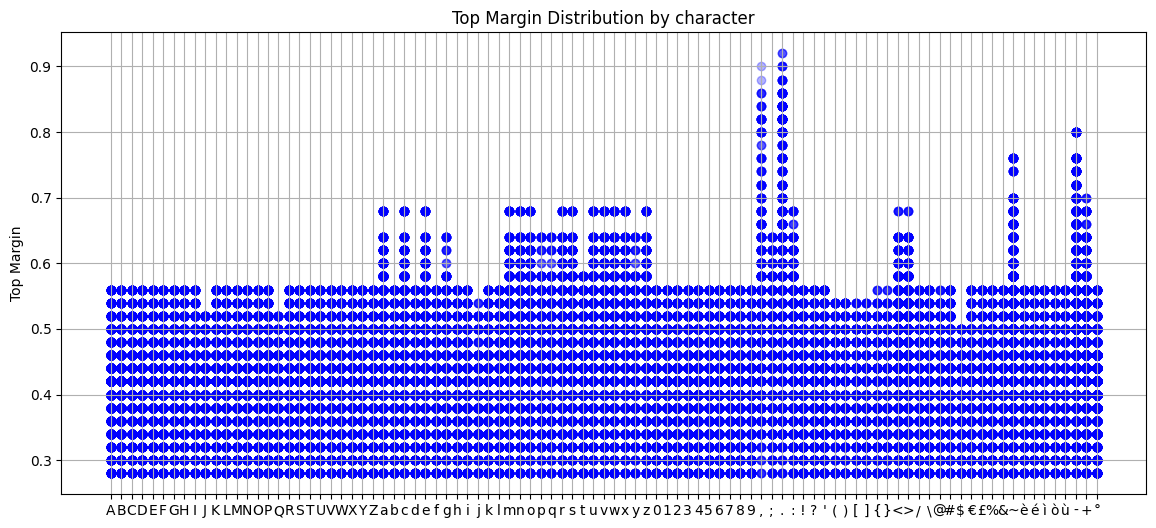

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.scatter(df['char'], df['top_margin'], alpha=0.3, c='blue')
plt.ylabel('Top Margin')
plt.title('Top Margin Distribution by character')
plt.grid(True)
plt.show()

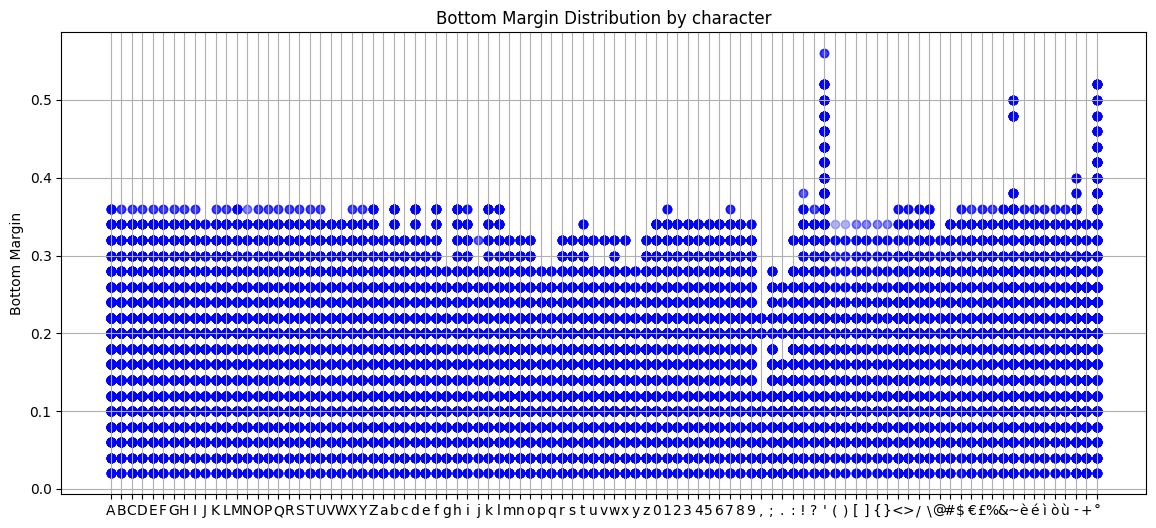

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.scatter(df['char'], df['bottom_margin'], alpha=0.3, c='blue')
plt.ylabel('Bottom Margin')
plt.title('Bottom Margin Distribution by character')
plt.grid(True)
plt.show()